<footer id="footer"></footer>

# <center> Рынок заведений общественного питания Москвы </center>

<p align="center"><img src='https://i.ibb.co/XtL9vq3/3-1.jpg'></p>

**Контекст**

Мы решили открыть небольшое кафе в Москве, в котором гостей должны обслуживать роботы. Вместе с партнёрами мы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность?


Партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

---
    
[Презентация](https://drive.google.com/file/d/1oe_KrljdOmxzpEmMagyodPVsQCUR7Gta/view?usp=sharing) представлена по ссылке. Формат `pdf`

## Загрузка данных

### Импорт необходимых библиотек

In [1]:
%%capture
!gdown --id 1okUPawUrmYguB1JkH_kvlqxy9TJqJB-j

In [2]:
%%capture
!pip install geopandas

In [3]:
%%capture
!pip install folium

In [4]:
%%capture
!pip install geopy==1.22.0

In [5]:
import re
import io

import pandas as pd
import numpy as np 
import requests
import warnings
import math
import folium

import geopandas as gpd
from folium import Choropleth, Marker
from folium.plugins import MarkerCluster, HeatMap
from geopandas.tools import geocode
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from textwrap import wrap
from tqdm import notebook
from tqdm import tqdm

sns.set_style('darkgrid')
sns.set_palette('muted') 
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('chained_assignment', None)
np.random.seed(42)

print(sys.getrecursionlimit())

3000


In [6]:
def get_info(data):
    display(data.head())
    display(data.describe().T)
    print('----')
    print('Информация о пропусках и типах данных')
    print('----')
    print()
    data.info()
    print('----')
    print()

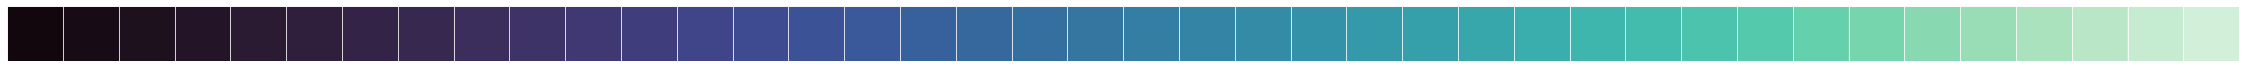

In [7]:
current_palette = sns.color_palette('mako', 40)
sns.palplot(current_palette)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

In [8]:
try:
  path = '/content/rest_data.csv'
  rest_data = pd.read_csv(path)
except:
  path = '/datasets/rest_data.csv'
  rest_data = pd.read_csv(path)

In [9]:
get_info(rest_data)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


,count,mean,std,min,25%,50%,75%,max
id,15366.0,119720.066901,73036.130732,838.0,28524.0,144974.5,184262.25,223439.0
number,15366.0,59.547182,74.736833,0.0,12.0,40.0,80.00,1700.0


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
----



In [10]:
print(f'Количество дубликатов в данных: {rest_data.duplicated().sum()}')

Количество дубликатов в данных: 0


Артибутивный состав данных:  

`id` — идентификатор объекта;  
`object_name` — название объекта общественного питания;  
`chain` — сетевой ресторан;  
`object_type` — тип объекта общественного питания;  
`address` — адрес;  
`number` — количество посадочных мест.

### Вывод



В работе открытые данные о заведениях общественного питания в Москве. Сет состоит из 5 признаков. Пропусков нет. Метод `describe` показывает, что имеем скошенное влево распределение - среднее меньше медианы. Типы данных удовлетворительные, но мы можем оптимизировать сет, снизив диапазон ёмкости хранения с `int64` до `int32`, также приведем значения всех категориальных переменных к нижнему регистру для удобства анализа. Также есть объекты с `0` посадочных мест - видимо точки питания с выдачей на улице. Посмотрим в дальнейшем, возможно стоит от них избавиться - так как нас интересуют точки с посадочными местами. Также - у нас очень длинные названия некоторых объектов - крайне неудобно для визуализации - изменим их

---
    
 <font size="1"> 
Изменения ниже </font>


In [11]:
nums_col = list(rest_data.select_dtypes(include=('int64')).columns)
for col in nums_col:
    rest_data[col] = rest_data[col].astype('int32')

Приведем к нижнему регистру:

In [12]:
cat_cols = list(rest_data.select_dtypes(exclude=('int32')).columns)

for col in cat_cols:
    if col != 'object_type':
        rest_data[col] = rest_data[col].str.lower()
    else:
        rest_data[col] = rest_data[col].str.lower()
        rest_data[col] = ['\n'.join(wrap(x, 12)) for x in rest_data[col]]

In [13]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int32
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int32
dtypes: int32(2), object(4)
memory usage: 600.4+ KB


In [14]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Анализ данных

Проверим уникальны ли наши значений id:

In [15]:
rest_data[rest_data.duplicated(subset=['id'])].shape[0]

0

### Соотношение видов объектов общественного питания по количеству

In [16]:
(rest_data['object_type']
 .value_counts(normalize=True)
 .to_frame().style.set_caption('Данные по процентному соотношению '
                              'представленных объектов общественного питания')
 .set_precision(2).background_gradient(low=0.2)
 
 )

,object_type
кафе,0.4
столовая,0.17
ресторан,0.15
предприятие быстрого обслуживания,0.13
бар,0.056
буфет,0.038
кафетерий,0.026
закусочная,0.023
магазин (отдел кулинарии),0.018


Как видим, большинство представленных точек общественного питания - являются кафе, далее идут столовые, рестораны и предприятия общественного питания. Перед непосредственным анализом, уберем объекты с нулевыми местами - мы собираемся открывать кафе с официантами, с посадочными местами. Исследовать заведения на вынос не будем

In [17]:
df = rest_data.loc[~(rest_data['number'] == 0)]

In [18]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


Посмотрим как изменились доли в нашем сете:

In [19]:
(df['object_type']
 .value_counts(normalize=True)
 .to_frame().style.set_caption('Данные по процентному соотношению '
                              'представленных объектов общественного питания')
 .set_precision(2).background_gradient(low=0.2)
 
 )

,object_type
кафе,0.42
столовая,0.19
ресторан,0.16
предприятие быстрого обслуживания,0.089
бар,0.06
буфет,0.038
кафетерий,0.021
закусочная,0.012
магазин (отдел кулинарии),0.0093


Особых изменений критичных не наблюдаем. Будем работать с таким сетом. Найдем общее количество объектов общественного питания, а затем - их долю среди остальных для нашей гистограммы

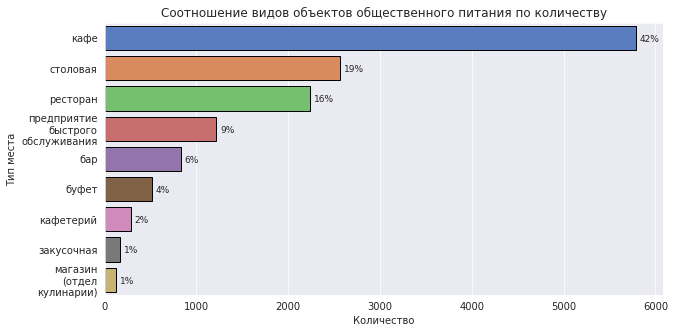

In [20]:
plt.figure(figsize=(10, 5))

types = (df.groupby('object_type')['id']
         .agg('count')
         .sort_values(ascending=False)
         .reset_index()
         )

types.columns = ['object_type','cnt']

ax = sns.barplot(y='object_type', x='cnt', data=types)
            


for patch in ax.patches:
    patch.set_edgecolor('black')
    percentage = '{:.0f}%'.format(100 * patch.get_width()/len(df))
    x = patch.get_x() + patch.get_width() + 42
    y = patch.get_y() + patch.get_height() / 2 + 0.12
    ax.annotate(percentage, (x, y), size = 9)


plt.xlabel('Количество')
plt.ylabel('Тип места')
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.show()

Как выше обозначили, больше всего в нашем сете данных о кафе, столовых и ресторанов


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

###  Соотношение сетевых и несетевых заведений по количеству

In [21]:
(df['chain']
 .value_counts(normalize=True)
 .to_frame().style.set_caption('Данные по процентному соотношению '
                              'сетевых объектов и несетевых')
 .set_precision(2).background_gradient(low=0.2)
 
 )

,chain
нет,0.8
да,0.2


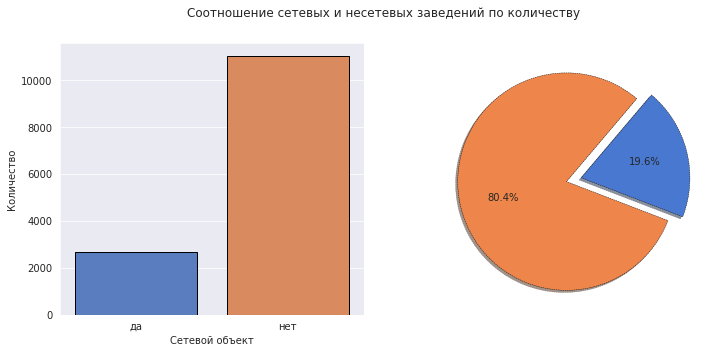

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
chain_cnt = df.groupby('chain', as_index=False)['id'].count()
ax = sns.barplot(x='chain', y='id', data=chain_cnt)

for patch in ax.patches:
    patch.set_edgecolor('black')

plt.suptitle('Соотношение сетевых и несетевых заведений по количеству')
plt.ylabel('Количество')
plt.xlabel('Сетевой объект')

plt.subplot(122)
plt.pie(chain_cnt['id'], autopct='%1.1f%%',
       wedgeprops={'edgecolor':'black','linewidth': .42, 
      'linestyle': '--', 'antialiased': True}, shadow=True,
      rotatelabels=False, explode = (.04, 0.1),
      startangle=-21, labeldistance=.15)

plt.show()

В нашем сете представлено больше объектов несетевого расространения. Посмотрим для какого вида объекта общественного питания характерно сетевое распространение

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Сетевое распространение

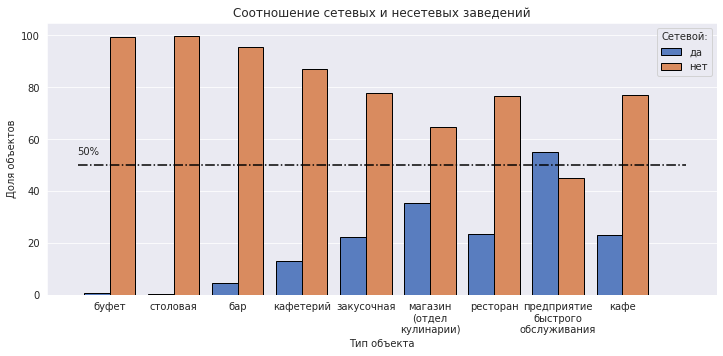

In [23]:
chained = df.groupby(['object_type', 'chain'])['id'].agg('count').reset_index()
chained = chained.rename(columns={'id': 'chain_cnt'})
report = (pd.merge(chained, types, on='object_type')
          .assign(frac = lambda x: x['chain_cnt'] / x['cnt'] * 100)
          .sort_values(by=['chain','chain_cnt'], ascending=True)

)

plt.figure(figsize=(12, 5))

ax = sns.barplot(x='object_type', 
                 y='frac', 
                 hue='chain', 
                 data=report
                 )

for patch in ax.patches:
    patch.set_edgecolor('black')

plt.title('Соотношение сетевых и несетевых заведений')
plt.ylabel('Доля объектов')
plt.xlabel('Тип объекта')
plt.legend(title='Сетевой:')
plt.hlines(y=50, xmin=-0.5, xmax=9, linestyle='dashdot', label='50%')
plt.text(-0.5, 55, '50%', ha='left', va='center')
plt.show()

Мы видим, что сетевое распространение характерно для предприятий быстрого обслуживания: доля сетевых объектов составляет около 55% среди заведений данного вида. Посмотрим на гистаграмму мест сетевых заведений

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Посадочные места сетевых заведений

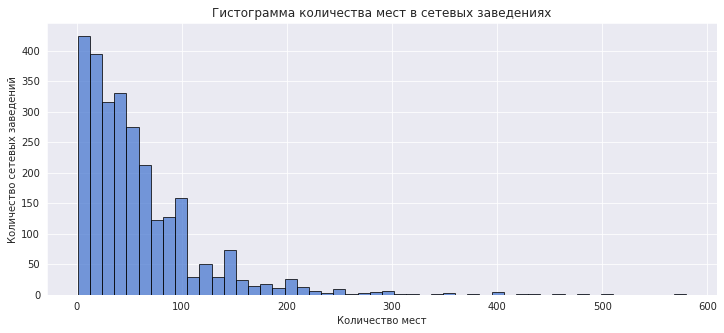

In [24]:
plt.figure(figsize=(12, 5))
df[df['chain']=='да']['number'].hist(bins=50, ec='black', alpha=.74)
plt.title('Гистограмма количества мест в сетевых заведениях')
plt.xlabel('Количество мест')
plt.ylabel('Количество сетевых заведений')
plt.show()

По гистограмме мы видим, что для сетевых заведений характерно небольшое количество мест, то есть тип развития: много заведений с небольшим числом посадочных мест в каждом 

In [25]:
perc = np.percentile(df[df['chain']=='да']['number'], [25, 50, 95])
no_seats = len(rest_data.loc[(rest_data['chain']=='да') & (rest_data['number']==0)])

print(f'У 25 % заведений не более {perc[0]} посадочных мест, '
      f'у 50 % заведений не более {perc[1]} посадочных мест, '
      f'у 95 % заведений не более {perc[2]} посадочных мест, ')
print(f'Число заведений без посадочных мест: {no_seats}')

У 25 % заведений не более 20.0 посадочных мест, у 50 % заведений не более 43.0 посадочных мест, у 95 % заведений не более 160.0 посадочных мест, 
Число заведений без посадочных мест: 268


### Посадочные места по видам объектов

In [26]:
mean_rep = (df.groupby('object_type')['number']
            .agg('mean')
            .sort_values(ascending=False)
            .reset_index()
           )

In [27]:
mean_rep

,object_type,number
0,столовая,131.210280
1,ресторан,98.779464
2,буфет,57.854932
3,бар,44.964976
4,кафе,41.842805
5,предприятие\nбыстрого\nобслуживания,32.421657
6,закусочная,16.017544
7,кафетерий,12.740351
8,магазин\n(отдел\nкулинарии),11.921875


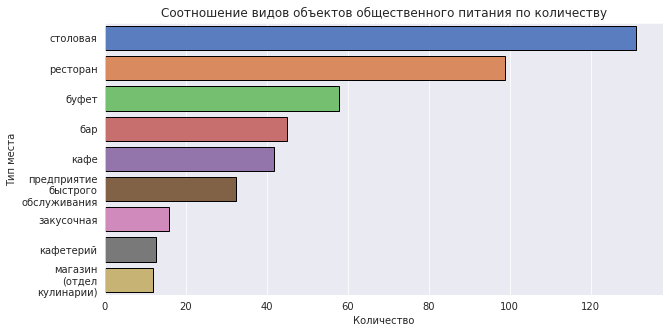

In [28]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(y='object_type', x='number', data=mean_rep)
for patch in ax.patches:
    patch.set_edgecolor('black')
plt.xlabel('Количество')
plt.ylabel('Тип места')
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.show()

Столовым и ресторанам характерно большое количество мест в среднем. В основном - у заведений менее 60 мест

In [29]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


In [30]:
data = df.copy()

Посмотрим распредление среднего количества мест:

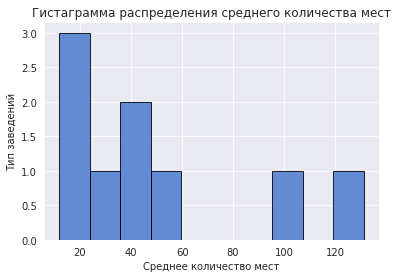

In [31]:
mean_rep.hist(ec='black', alpha=.84)
plt.ylabel('Тип заведений')
plt.xlabel('Среднее количество мест')
plt.title('Гистаграмма распределения среднего количества мест')
plt.show()

У нас множество выбросов. Через pd.qcut выделим 4 категории по количеству мест

In [32]:
data['number_bin'] = pd.qcut(data['number'],
                               q=[0, .25, .5, .75, 1.],
                               labels=['до 20 мест', 'до 44 мест', 'до 85 мест', 'свыше 85 мест'])

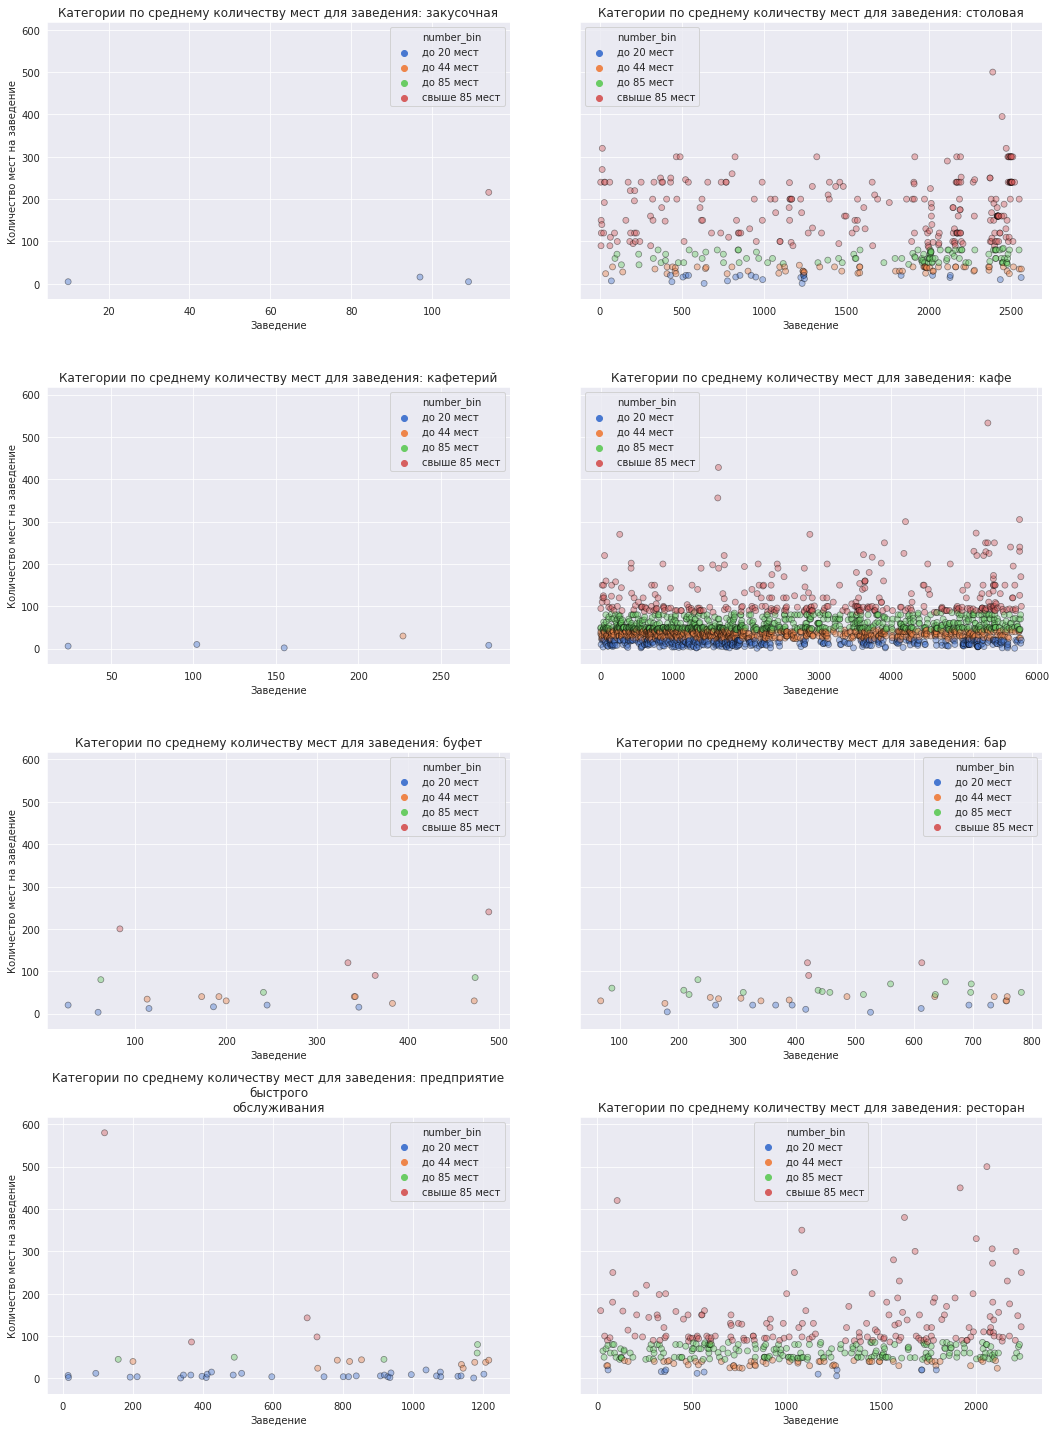

In [33]:
object_list = list(set(data[data['object_type'] !='магазин\n(отдел\nкулинарии)']['object_type'].tolist()))
fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharey=True)

for obj, ax in zip(object_list, axes.flatten()):

    cat_data = data.query('object_type == @obj')
    x_values = pd.Series(range(0, len(cat_data)))
    sns.scatterplot(data=cat_data, x=x_values, y='number', hue='number_bin', ax=ax,
                   edgecolor='black', alpha=0.42)
    ax.set_title(f'Категории по среднему количеству мест для заведения: {obj}')
    ax.set_ylabel('Количество мест на заведение')
    ax.set_xlabel('Заведение')
plt.tight_layout()

Мы видим, что для столовых, ресторанов - то есть больших заведений - характерно большое число посадочных мест, в то время  как для кафетерия или закусочной, рассчитанной на недлительное время провождения - число мест менее 20. Больше всего в сете представлено кафе, для которых характерно до 85 мест

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Среднее количество посадочных мест

Изучим среднее число посадочных мест для различных типов предприятий общественного питания

In [34]:
report = (df.groupby('object_type')['number']
      .agg('mean')
      .transform(lambda x: round(x, 2))
      .to_frame()
      .sort_values(by='number', ascending=False).reset_index()
 )

In [35]:
report

,object_type,number
0,столовая,131.21
1,ресторан,98.78
2,буфет,57.85
3,бар,44.96
4,кафе,41.84
5,предприятие\nбыстрого\nобслуживания,32.42
6,закусочная,16.02
7,кафетерий,12.74
8,магазин\n(отдел\nкулинарии),11.92


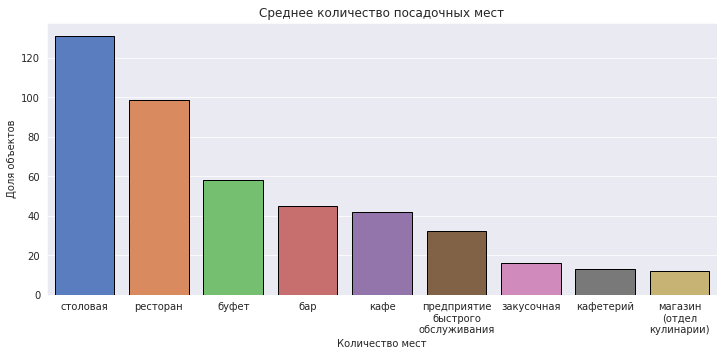

In [36]:
plt.figure(figsize=(12, 5))

ax = sns.barplot(x='object_type', 
                 y='number', 
                 data=report
                 )

for patch in ax.patches:
    patch.set_edgecolor('black')

plt.title('Среднее количество посадочных мест')
plt.ylabel('Доля объектов')
plt.xlabel('Количество мест')

plt.show()

В среднем, лидируют по количеству мест столовые и рестораны. Далее располагаются буфеты.   

Столовые, обычно располагаются в учебных заведениях, предприятиях (на производстве) и расчитаны на то, чтобы вместить наибольшее количество людей за время обеденного перерыва, что связано со строгим графиком и расписанием. Стоит взглянуть на коробчатые диаграммы, так как у нас было скошенное распределение. Возможно, в данных есть выбросы

In [37]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


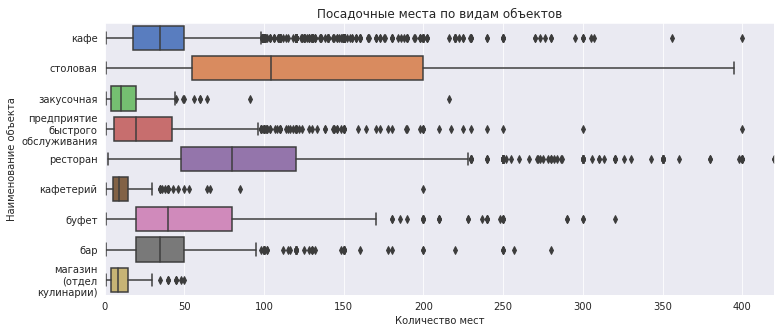

In [38]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='number', 
            y='object_type',
            data=df,
            orient='h')
plt.xlim(0, 420)
plt.title('Посадочные места по видам объектов')
plt.ylabel('Наименование объекта')
plt.xlabel('Количество мест')
plt.show()

Как видим, в столовых чаще всего большое количество мест (относительно, более 100), кафе и рестораны с большим количеством мест встречаются реже

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Информация об улицах

In [39]:
df_street = df.copy()

Получим наши улицы:

In [40]:
# Код ревьюера

sample_str = "Москва, Зеленоград, улица Улица"
sample_str[(sample_str.find(',') + 1) : sample_str.find(',',(sample_str.find(',') + 1))]

' Зеленоград'

In [41]:
def text_preprocessing(corpus):
    start = corpus.find(',') + 1
    end = corpus.find(',', start)
    return corpus[start:end].strip()

In [42]:
%%capture
tqdm.pandas() 
df_street['streets'] = df_street['address'].progress_apply(text_preprocessing)

In [43]:
df_street.head()

,id,object_name,chain,object_type,address,number,streets
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


Проверим пропуски:

In [44]:
df_street['streets'].isna().mean()

0.0

Теперь мы можем выделить топ-10 улиц для расположения мест общественного питания

In [45]:
report = (df_street.groupby('streets')['id']
          .agg('count').
          sort_values(ascending=False)
          .reset_index()
          )
report.columns=['streets','cnt']

In [46]:
mask = (report['streets'] != 'город зеленоград') & (report['streets'] !='поселение сосенское')
report_top = report[mask].nlargest(10, 'cnt').reset_index(drop=True)

In [47]:
def replacer(series_):
    if 'улица' in series_:
        series_ =  series_.replace('улица', 'ул.')
    elif ' проспект' in series_:
        series_ =  series_.replace('проспект', 'пр-т.')
    elif 'шоссе' in series_:
        series_ =  series_.replace('шоссе', 'ш.')
    return series_

report_top['streets'] = report_top['streets'].apply(replacer)

In [48]:
report_top.head()

,streets,cnt
0,проспект мира,192
1,ленинградский пр-т.,158
2,пресненская набережная,156
3,профсоюзная ул.,142
4,варшавское ш.,140


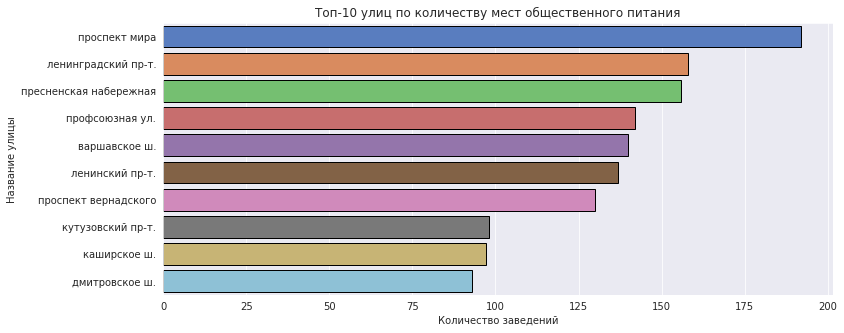

In [49]:
plt.figure(figsize=(12, 5))

ax = sns.barplot(x='cnt', 
                 y='streets', 
                 data=report_top
                 )

for patch in ax.patches:
    patch.set_edgecolor('black')


plt.title('Топ-10 улиц по количеству мест общественного питания')
plt.ylabel('Название улицы')
plt.xlabel('Количество заведений')

plt.show()

Изучим районы. Нам необходимо дополнить наши адреса принадлежностью к тому ил ииному району. Воспользуемся хабом открытых данных и загрузим информацию по адресам Москвы. После поиска подходящих данных - лучше всего подходят для данной задачи ```Список всех улиц Москвы и их привязка к районам с сайта МосГаз``` так как содержат информацию об округах. Были также загружены и иные сеты, но это единственный сет, позволивший загрузить полную информацию об улицах

In [50]:
URL = 'https://frs.noosphere.ru/xmlui/bitstream/handle/' \
      '20.500.11925/714058/mosgaz-streets.csv?sequence=1'
response = requests.get(URL)
data = io.StringIO(response.content.decode('utf-8'))
districts = pd.read_csv(data, error_bad_lines=False)

districts['streetname'] = districts['streetname'].str.lower()
districts['streetname'] = districts['streetname'].apply(replacer)

In [51]:
districts.head()

,streetname,areaid,okrug,area
0,выставочный переулок,17,ЦАО,Пресненский район
1,ул. гашека,17,ЦАО,Пресненский район
2,большая никитская ул.,17,ЦАО,Пресненский район
3,глубокий переулок,17,ЦАО,Пресненский район
4,большой гнездниковский переулок,17,ЦАО,Пресненский район


Нам необходимо дополнить наши адреса информацией о районе Москвы

In [52]:
district_info = (pd.merge(report_top, 
                          districts, 
                          left_on='streets', 
                          right_on='streetname', 
                          how='left')
)

In [53]:
district_info = district_info.drop('streetname', axis=1)


In [54]:
district_info.head()

,streets,cnt,areaid,okrug,area
0,проспект мира,192,70,СВАО,Алексеевский район
1,проспект мира,192,86,СВАО,Ярославский Район
2,проспект мира,192,78,СВАО,Район Марьина роща
3,проспект мира,192,79,СВАО,Останкинский район
4,проспект мира,192,81,СВАО,Район Ростокино


Некоторые длинные улицы, шоссе и проспекты располагаются в нескольких районах. Сгруппируем их и присоединим к топ-10 ули и посмотрим, в каких районах чаще всего располагаются точки общественного питания

In [55]:
pd.set_option('max_colwidth', 200)

area_data = (district_info.groupby(['streets'])['area']
                 .apply(lambda x: ''.join(x.to_string(index=False)))
                 .str.replace('(\\n)', ',')
                 .reset_index()
                 )
top_10 = report_top.merge(area_data, left_on='streets', right_on='streets', how='left')

In [56]:
top_10

,streets,cnt,area
0,проспект мира,192,"Алексеевский район, Ярославский Район, Район Марьина роща, Останкинский район, Район Ростокино, Район Свиблово, Мещанский район"
1,ленинградский пр-т.,158,"Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол"
2,пресненская набережная,156,Пресненский район
3,профсоюзная ул.,142,"Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан"
4,варшавское ш.,140,"Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Северное ..."
5,ленинский пр-т.,137,"Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан,..."
6,проспект вернадского,130,"Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино, Район Гагаринский, Ломоносовский район"
7,кутузовский пр-т.,98,"Район Дорогомилово, Район Фили-Давыдково"
8,каширское ш.,97,"Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное"
9,дмитровское ш.,93,"Бескудниковский Район, Дмитровский район, Тимирязевский Район, Район Восточное Дегунино, Район Западное Дегунино, Район Лианозово, Район Северный"


Большинство мест общественного питания располагаются на протяженных улицах, шоссе и проспектах, рассосредоточены по районам. По округам - рапространение достаточно равномерное

Получим координаты для топ-10 улиц, с помощью `nominatim`

In [57]:
def geocoder(row):
    try:
        point = geocode(row, provider='nominatim').geometry.iloc[0]
        return pd.Series({'Latitude': point.y, 'Longitude': point.x, 'geometry': point})
    except:
        return None

In [58]:
follium_top = df_street[df_street['streets'].apply(replacer).isin(report_top['streets'])]

In [59]:
follium_top['streets'] = ['Москва '] + follium_top['streets']

In [60]:
follium_top[['Latitude', 'Longitude', 'geometry']] = follium_top.apply(lambda x: geocoder(x['streets']), axis=1)

In [61]:
print("{}%  улиц были геокодированы!".format(
    (1 - sum(np.isnan(follium_top["Latitude"])) / len(follium_top)) * 100))

99.70215934475057%  улиц были геокодированы!


In [62]:
df_q = follium_top.loc[~np.isnan(follium_top["Latitude"])].copy()

Теперь создадим Follium Тепловую карту

In [63]:
%%capture
cities = gpd.GeoDataFrame(df_q, geometry=df_q.geometry)
cities.crs = {'init': 'epsg:4326'}

In [64]:
cities.head()

,id,object_name,chain,object_type,address,number,streets,Latitude,Longitude,geometry
151,155973,кафе «андерсон»,да,кафе,"город москва, варшавское шоссе, дом 2",150,Москва варшавское шоссе,55.65427,37.619383,POINT (37.61938 55.65427)
152,23618,кафе «subway»,да,кафе,"город москва, варшавское шоссе, дом 7, корпус 1",36,Москва варшавское шоссе,55.65427,37.619383,POINT (37.61938 55.65427)
153,155852,кафе «ламаджо»,нет,кафе,"город москва, варшавское шоссе, дом 29",30,Москва варшавское шоссе,55.65427,37.619383,POINT (37.61938 55.65427)
155,120658,выпечка,нет,кафетерий,"город москва, варшавское шоссе, дом 100",2,Москва варшавское шоссе,55.65427,37.619383,POINT (37.61938 55.65427)
156,26279,ресторан «макдоналдс»,да,кафе,"город москва, варшавское шоссе, дом 143а",70,Москва варшавское шоссе,55.65427,37.619383,POINT (37.61938 55.65427)


In [65]:
agg_sum = pd.merge(cities.groupby('streets')['id'].agg('count').reset_index(),
                   cities[['streets', 'Latitude', 'Longitude']].drop_duplicates('streets'), on='streets', left_index=True)

In [66]:
agg_sum.head()

,streets,id,Latitude,Longitude
151,Москва варшавское шоссе,139,55.654270,37.619383
321,Москва дмитровское шоссе,92,55.916626,37.544017
405,Москва каширское шоссе,97,55.667926,37.629036
295,Москва кутузовский проспект,98,55.739942,37.534668
541,Москва ленинградский проспект,158,55.790616,37.553989


In [67]:
agg_sum['lat'] = agg_sum['Latitude'].astype(float).fillna(0)
agg_sum['long'] = agg_sum['Longitude'].astype(float).fillna(0)

In [68]:
m_1 = folium.Map(location=[55.7526, 37.6199], tiles='cartodbpositron', zoom_start=10)
HeatMap(data=cities[['Latitude', 'Longitude']], radius=21, max_zoom=12).add_to(m_1)
mc = MarkerCluster()
for idx, row in agg_sum.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']],
                            tooltip=[round(row['id'], 2), row['streets']]))
    
m_1.add_child(mc)    
m_1

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Число улиц с одним объектом общественного питания

Посмотрим те улицы, где 1 объект общественного питания

In [69]:
report = (df_street.groupby('streets')['id']
          .agg('count').
          sort_values(ascending=True)
          .reset_index()
          )
report.columns=['streets','cnt']

In [70]:
one_point = report[report['cnt'] == 1]
print(f'Число улиц с одним объектом питания: {one_point.shape[0]}')

Число улиц с одним объектом питания: 582


Объединим такие улицы с данными по районам

In [71]:
district_info_all = (pd.merge(report, 
                          districts, 
                          left_on='streets', 
                          right_on='streetname', 
                          how='left')
)

summary = district_info_all[district_info_all['cnt'] == 1]

In [72]:
area_data = (summary.groupby(['streets'])['area']
                 .apply(lambda x: ''.join(x.to_string(index=False)))
                 .str.replace('(\\n)', ',')
                 .str.strip()
                 .reset_index()

                 )


In [73]:
summary.merge(area_data, left_on='streets', right_on='streets', how='left')
summ = summary.copy()
summ['area'] = np.where(summary['area'] == 'NaN', np.nan, summary['area'])
summ.dropna(inplace=True)

In [74]:
data = (summ.
        groupby('area')['cnt']
        .agg('count')
        .sort_values(ascending=False)
        .to_frame()
        .reset_index()
        )

Получили сет, с количеством объектов по районам

In [75]:
data.head()

,area,cnt
0,Район Хамовники,24
1,Басманный район,22
2,Таганский район,19
3,Тверской район,16
4,Район Арбат,16


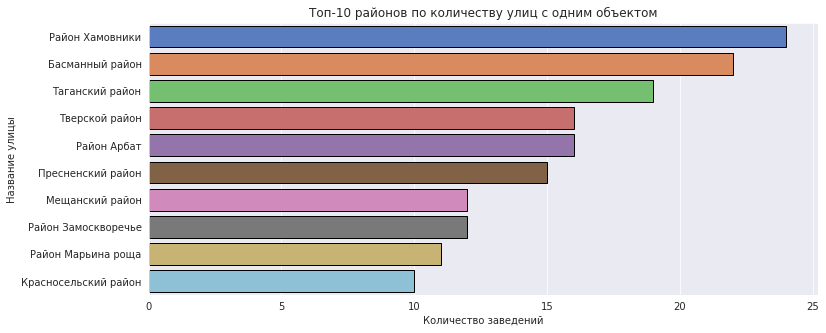

In [76]:
plt.figure(figsize=(12, 5))

ax = sns.barplot(x='cnt', 
                 y='area', 
                 data=data.nlargest(10, 'cnt')
                 )

for patch in ax.patches:
    patch.set_edgecolor('black')


plt.title('Топ-10 районов по количеству улиц с одним объектом')
plt.ylabel('Название улицы')
plt.xlabel('Количество заведений')

plt.show()

Мы видим, что в центральных районах наименьшее количество объектов общественного питания. Это может быть связано со следующими факторами:

1. Стоимость аренды достаточно высокая
2. Отсутствие точек для открытия - помещения могут охраняться как культурные ценности
3. Короткие улицы


Например, [Хамовники](https://realty.rbc.ru/news/5903444a9a7947bb64d2ac18) - достаточно востребованный район с дорогими ценами за кв.м.

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

Посмотрим как распределны посадочные места для улиц с самым большим количеством объектов общественного питания

In [77]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


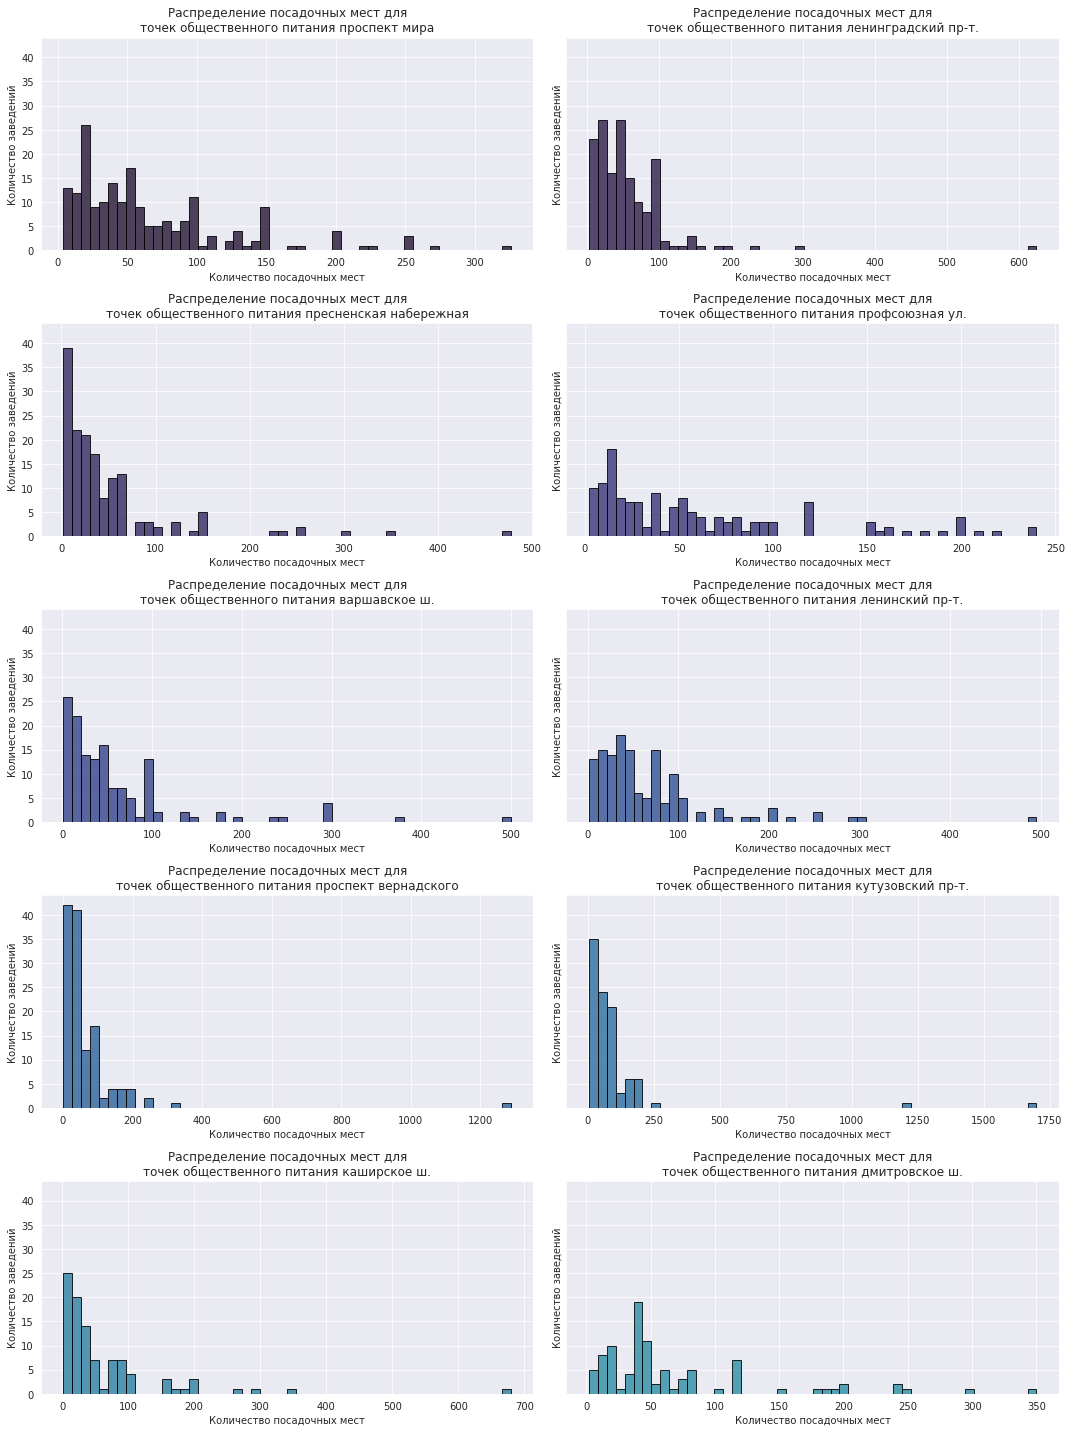

In [78]:
street_list = report_top['streets'].tolist()
df_street['streets'] = df_street['streets'].apply(replacer)
fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharey=True)

cnt = 5
for street, ax in zip(street_list, axes.flatten()):
    data = df_street.query('streets == @street')['number']
    data.hist(bins=50, ec='black', ax=ax, color=current_palette[cnt], alpha=.84)
    ax.set_title(f'Распределение посадочных мест для\nточек общественного питания {street}')
    ax.set_ylabel('Количество заведений')
    ax.set_xlabel('Количество посадочных мест')
    cnt += 2


plt.tight_layout()

Для наглядности посмотрим также коробчатую диаграмму

In [79]:
data = df_street.query('streets == @street_list')

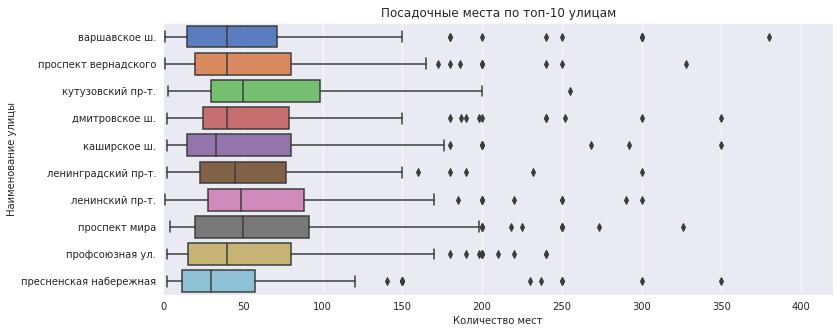

In [80]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='number', 
            y='streets',
            data=data,
            orient='h')
plt.xlim(0, 420)
plt.title('Посадочные места по топ-10 улицам')
plt.ylabel('Наименование улицы')
plt.xlabel('Количество мест')
plt.show()

In [81]:
perc = np.percentile(data['number'], [25, 50, 95])

print(f' У 25 % заведений на топ-10 улицах не более {perc[0]} посадочных мест,\n '
      f'у 50 % заведений на топ-10 улицах не более {perc[1]} посадочных мест,\n '
      f'у 95 % заведений на топ-10 улицах не более {perc[2]} посадочных мест, ')


 У 25 % заведений на топ-10 улицах не более 20.0 посадочных мест,
 у 50 % заведений на топ-10 улицах не более 40.0 посадочных мест,
 у 95 % заведений на топ-10 улицах не более 200.0 посадочных мест, 


Наши вывод подтверждаются - у 50% заведений не более 40 посадочных мест. Стоит отметить, что в основном, по заведениям - не более 200 посадочных мест

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___

## Вывод

Мы провели исследования на основе открытых данных о заведениях общественного питания в Москве.  

По итогу выяснили:  

- кафе являются наиболее популярными точками общественного питания;  
- сетевое распространение характерно точкам быстрого питания;
- сетевые кафе представлены в 23% случаев;
- для большинства предприятий общественного питания характерно не более 40 посадочных мест; 
- наибольшее количество точек общественного питания представлено на протяженных улицах города с высокой проходимостью;
- в Центральных округах меньше всего точек общественного питания


Таким образом, для предприятия рекомендуется расмотреть вариант открытия кафе с 40-50 посадочными местами, на протяженных улицах, н-р Проспект мира. Рекомендуется расмотреть сетевой формат развития в будущем


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

___